# Indicadores de riesgo

Pendiente implementar  https://quantspace.es/2019/11/22/analizando-series-temporales-con-python/#comment-7872

In [99]:
import os
import math
import pandas as pd
import datetime as dt
import yfinance as yf
import numpy as np
#from termcolor import 
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import skew,kurtosis,norm,skewtest,kurtosistest, norm
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# Set the plot style
#plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['figure.figsize'] = (15, 7)

plt.style.use('fivethirtyeight')

In [2]:
# To retrieve them in another script
#%store -r  df_yf_final
#%store -r  df_val_ind
#%store -r  df_R4_quotes
%store -r  df_val
%store -r  df_value
%store -r  nom_val
%store -r  df_ref
%store -r  df_reference
%store -r  nom_ref
%store -r df_val_ind

In [101]:
class CalculadorIndicadoresRiesgo:
    def __init__(self, ticker, start_date, end_date):
        self.start_date = start_date
        self.end_date = end_date
        self.ticker = ticker
        self.historical_quotes = None
        self.close_df = None
        self.close_df_ref = None
        self.name = None
        self.name_ref = None
        self.N = 255          # 255 días de bolsa en un año
        self.rf = 0.01
        self.CAGR = None
        self.Sharpe = None

    def get_quotes(self):
        """
        Obtiene los datos de cotización de los tickers en un rango de fechas.

        Returns:
        - historical_quotes_val: DataFrame con los datos históricos del ticker de valor.
        - historical_quotes_ref: DataFrame con los datos históricos del ticker de referencia.
        - close_df_val: DataFrame con los precios de cierre del ticker de valor.
        - close_df_ref: DataFrame con los precios de cierre del ticker de referencia.
        """
        yfObj = yf.Ticker(self.ticker)
        
        self.name = yfObj.info['shortName']
        
        self.historical_quotes = yf.download(self.ticker, start=self.start_date, end=self.end_date)
        
        self.close_df = self.historical_quotes[['Close']].rename(columns={'Close': self.name})
        
        return  self.historical_quotes, self.close_df
        
    def calculate_variations(self):
        """
        Calcula las variaciones, log-retornos y retornos acumulados de un DataFrame.
        
        Returns:
        - df: DataFrame con los datos actualizados.
        """
        # Calcular variaciones
        self.close_df["variations"] = self.close_df.diff()
    
        # Calcular log-retornos
        log_returns = np.log(self.close_df[self.name] / self.close_df[self.name].shift(1))
    
        # Eliminar filas con valores nulos en los log-retornos
        self.close_df = self.close_df.dropna(subset=['variations', self.name])
    
        # Asignar los log-retornos calculados al DataFrame
        self.close_df["log_returns"] = log_returns
    
        # Calcular retornos acumulados
        self.close_df["cum_returns"] = self.close_df["log_returns"].cumsum().apply(np.exp)
    
        return self.close_df


    def buy_hold_strategy_profits(self):
        """
        Calcula los beneficios de la estrategia de Comprar y Mantener (Buy and Hold).
        """
        buy_hold_profits = (self.close_df[self.name].iloc[-1] - self.close_df[self.name].iloc[0]) / self.close_df[self.name].iloc[0]
        print(f"\n- Buy and Hold strategy profits: {buy_hold_profits:.2%}")

    def calcular_CAGR(self):
        """
        Calcula la Tasa de Crecimiento Anual Compuesto (CAGR).
        """
        dias = (self.close_df.index[-1] - self.close_df.index[0]).days
        self.CAGR = ((self.close_df[self.name][-1] / self.close_df[self.name][0]) ** (1 / (365.0 / dias))) - 1
        print(f"\n- Tasa de Crecimiento Anual Compuesto (CAGR): {self.CAGR*100:.2f}%")

    def calcular_drowdown(self):
        """
        Calcula el Máximo Drawdown Histórico.
        """
        max_peak = self.close_df[self.name].cummax()
        drawdowns = 100 - ((self.close_df[self.name] - max_peak) / max_peak)
        max_drawdown = np.min(drawdowns)
        print(f"\n- Máximo Drawdown Histórico: {max_drawdown:.2f}%")

    def calcular_estadisticos(self):
        """
        Calcula estadísticas básicas.
        """
        print(f"\n- Número de días analizados: {self.close_df.shape[0]}")
        print(f"- Rendimiento diario promedio: {self.close_df['log_returns'].mean()*100:.2f}%")
        print(f"- Desviación estándar diaria: {self.close_df['log_returns'].std(ddof=1)*100:.2f}%")
        print(f"- Pérdida diaria máxima: {self.close_df['log_returns'].min()*100:.2f}%")
        print(f"- Ganancia diaria máxima: {self.close_df['log_returns'].max()*100:.2f}%")

    def calculate_asimmetry(self):
        """
        Calcula el coeficiente de asimetría y la curtosis de la distribución de retornos.
        """
        print('\n- Coeficiente de Asimetría:', self.close_df['log_returns'].skew())
        print('- Curtosis:', self.close_df['log_returns'].kurt())

    def theoretical_var(self):
        """
        Calcula el VaR Teórico obtenido a través de la distribución normal al 95% y 99% de confianza.
        """
        (mu, sigma) = stats.norm.fit(self.close_df['log_returns'])
        print(f"\n- VaR Gaussian model NC-95%: {norm.ppf(0.05, mu, sigma)*100:.2f}%")
        print(f"- VaR Gaussian model NC-99%: {norm.ppf(0.01, mu, sigma)*100:.2f}%")
        print(f"- VaR Gaussian model NC-99.7%: {norm.ppf(0.003, mu, sigma)*100:.2f}%")

    def historical_var(self):
        """
        Calcula el VaR histórico al 95% y 99% de confianza.
        """
        print('\n- VaR Histórico al 95% y 99% de confianza:')
        print(f"> VaR Gaussian model NC-95%: {np.percentile(self.close_df['log_returns']*100, 5):.2f}%")
        print(f"> VaR Gaussian model NC-99%: {np.percentile(self.close_df['log_returns']*100, 1):.2f}%")
        print(f"> VaR Gaussian model NC-99.7%: {np.percentile(self.close_df['log_returns']*100, 0.3):.2f}%")

    #----------------------------------------------------------------------------------------
    def calculate_volatility(self):
        """
        Calcula la evolución de la volatilidad en el rango de análisis.

        "Promedio sobre el porcentaje de días positivos": porcentaje de días en los que el precio de cierre del activo aumentó con respecto al día anterior, es decir, los días en los que se registraron ganancias.
        
        """
        print('\nEvolución de la volatilidad en el rango de análisis')
        
        # Volatilidad anualizada
        log_returns = np.log(self.historical_quotes['Close'] / self.historical_quotes['Close'].shift(1))
        self.VAM = 100 * log_returns.std() * (252 ** 0.5)
        
        # Volatilidad de 14 días
        self.historical_quotes['14_days_vol'] = log_returns.rolling(14).std() * 100
        
        # Volatilidad anualizada de 14 días
        self.historical_quotes['14_days_ann_vol'] = self.historical_quotes['14_days_vol'] * (251 ** 0.5)
        
        # Media de los últimos 126 valores de la volatilidad anualizada
        self.historical_quotes['SMA_126_ann_vol'] = self.historical_quotes['14_days_vol'].rolling(126).mean()
        
        # Fechas y volatilidad anualizada máxima y mínima
        date_min_vol = self.historical_quotes['14_days_ann_vol'][self.historical_quotes['14_days_ann_vol'] == self.historical_quotes['14_days_ann_vol'].min()].index.strftime('%Y-%m-%d').tolist()
        date_max_vol = self.historical_quotes['14_days_ann_vol'][self.historical_quotes['14_days_ann_vol'] == self.historical_quotes['14_days_ann_vol'].max()].index.strftime('%Y-%m-%d').tolist()        
        print(f"- Volatilidad anualizada mínima: {self.historical_quotes['14_days_ann_vol'].min():.2f}%, registrado el {date_min_vol}")
        print(f"- Volatilidad anualizada máxima: {self.historical_quotes['14_days_ann_vol'].max():.2f}%, registrado el {date_max_vol}")
        
        print('\nPromedio sobre el porcentaje de días negativos.')
        self.historical_quotes['negative_days'] = np.where(log_returns < 0, 100 * (self.historical_quotes['High'] - self.historical_quotes['Low']) / self.historical_quotes['Low'], 0)
        mean_negative_days = self.historical_quotes['negative_days'].mean()
        print(f"- Promedio de días negativos: {mean_negative_days:.2f}%")
        
        print('\nPromedio sobre el porcentaje de días positivos.')
        self.historical_quotes['positive_days'] = np.where(log_returns > 0, 100 * (self.historical_quotes['High'] - self.historical_quotes['Low']) / self.historical_quotes['Low'], 0)
        mean_positive_days = self.historical_quotes['positive_days'].mean()
        print(f"- Promedio de días positivos: {mean_positive_days:.2f}%")
        
        print('\nRatio del rango entre días positivos y negativos')
        print(f"- Ratio RND/RPD: {(mean_negative_days / mean_positive_days) * 100:.2f}%")

    def mostrar_volatilidad_matplotlib(self):
        # Graficar las cotizaciones
        plt.figure(figsize=(15, 5))
        plt.plot(self.historical_quotes.index, self.historical_quotes['Close'], 'red', label='Precios de cierre', lw=1.5)
        plt.title('Evolución histórica de precios')
        plt.xlabel('Fecha')
        plt.ylabel('Precio de cierre')
        plt.grid(True)
        plt.legend(loc='upper left', frameon=True, borderpad=1)
        plt.show()
    
        # Graficar la volatilidad de 14 días
        fig, ax1 = plt.subplots(figsize=(15, 5))
        ax1.plot(self.historical_quotes.index, self.historical_quotes['14_days_ann_vol'], 'green', linestyle='-', label='Volatilidad anualizada de 14 días', lw=1.5)
        ax1.set_xlabel('Fecha')
        ax1.set_ylabel('Volatilidad anualizada', color='black')
        ax1.grid(True)
        ax1.legend(loc='upper left', frameon=True, borderpad=1)
        plt.show()
    
        # Graficar la SMA de 126 días
        fig, ax2 = plt.subplots(figsize=(15, 5))
        ax2.plot(self.historical_quotes.index, self.historical_quotes['SMA_126_ann_vol'], linestyle='-', label='SMA 126 volatilidad anualizada', lw=1.5)
        ax2.set_xlabel('Fecha')
        ax2.set_ylabel('Volatilidad anualizada', color='black')
        ax2.grid(True)
        ax2.legend(loc='upper left', frameon=True, borderpad=1)
        plt.show()
    
        print(80 * '=')

    def mostrar_volatilidad_plotly(self):
        # Crear la figura con subgráficos
        fig = make_subplots(rows=2, cols=1, shared_xaxes=True,
                            subplot_titles=('Volatilidad anualizada de 14 días', 'SMA 126 volatilidad anualizada'))

        # Agregar la volatilidad de 14 días al primer subplot
        fig.add_trace(go.Scatter(x=self.historical_quotes.index, y=self.historical_quotes['14_days_ann_vol'],
                                 mode='lines', name='Volatilidad anualizada de 14 días', line=dict(color='green')),
                      row=1, col=1)
        
        # Agregar la SMA de 126 días al segundo subplot
        fig.add_trace(go.Scatter(x=self.historical_quotes.index, y=self.historical_quotes['SMA_126_ann_vol'],
                                 mode='lines', name='SMA 126 volatilidad anualizada', line=dict(color='blue')),
                      row=2, col=1)

        # Configurar el diseño de la figura
        fig.update_layout(title='Evolución histórica de volatilidades', height=600, width=1000)
        
        # Mostrar la figura
        fig.show()

    def calcular_sharpe_anualizado(self):
        """
        Calcula el ratio de Sharpe anualizado y lo grafica.
        """
        mean = self.close_df.mean() * self.N - self.rf
        sigma = self.close_df.std() * np.sqrt(self.N)
        self.Sharpe = mean / sigma
        self.sharpe_ratio_anual = (252 ** 0.5) * self.Sharpe
           
    def mostrar_tabla_indicadores(self):
        """
        Muestra una tabla con diversos indicadores y grafica el resultado acumulado.
        """
        self.df_val_macd_tabla_indicadores = pd.DataFrame()
        self.df_val_macd_tabla_indicadores['Sortino'] = self.sortino
        self.df_val_macd_tabla_indicadores['Sharpe Ratio'] = self.sharpe_ratio_anual
        self.df_val_macd_tabla_indicadores['Max Drawdown'] = self.max_drawdown
        self.df_val_macd_tabla_indicadores['Calmar Ratio'] = self.ratio_calmar
        self.df_val_macd_tabla_indicadores["CAGR"] = self.CAGR
        self.df_val_macd_tabla_indicadores["RSI"] = self.datos['RSI'][-1]
        
        (self.df_val_macd + 1).cumprod().plot(figsize=(8, 5))
        plt.table(cellText=np.round(self.df_val_macd_tabla_indicadores.values, 2), 
                  colLabels=self.df_val_macd_tabla_indicadores.columns,
                  rowLabels=self.df_val_macd_tabla_indicadores.index, rowLoc='center',
                  cellLoc='center', loc='top', colWidths=[0.25]*len(self.df_val_macd_tabla_indicadores.columns))
        plt.tight_layout()
        plt.show()
       
        
        

[*********************100%%**********************]  1 of 1 completed



- Buy and Hold strategy profits: -14.04%

- Número de días analizados: 3632
- Rendimiento diario promedio: -0.00%
- Desviación estándar diaria: 1.38%
- Pérdida diaria máxima: -15.15%
- Ganancia diaria máxima: 13.48%

- Buy and Hold strategy profits: -14.04%

- Tasa de Crecimiento Anual Compuesto (CAGR): -88.33%

- Máximo Drawdown Histórico: 100.00%

- Número de días analizados: 3632
- Rendimiento diario promedio: -0.00%
- Desviación estándar diaria: 1.38%
- Pérdida diaria máxima: -15.15%
- Ganancia diaria máxima: 13.48%

- Coeficiente de Asimetría: -0.5220431694393964
- Curtosis: 11.217954884618017

- VaR Gaussian model NC-95%: -2.27%
- VaR Gaussian model NC-99%: -3.21%
- VaR Gaussian model NC-99.7%: -3.80%

- VaR Histórico al 95% y 99% de confianza:
> VaR Gaussian model NC-95%: -2.15%
> VaR Gaussian model NC-99%: -3.70%
> VaR Gaussian model NC-99.7%: -5.18%

Evolución de la volatilidad en el rango de análisis
- Volatilidad anualizada mínima: 4.48%, registrado el ['2018-04-27']
- Vola

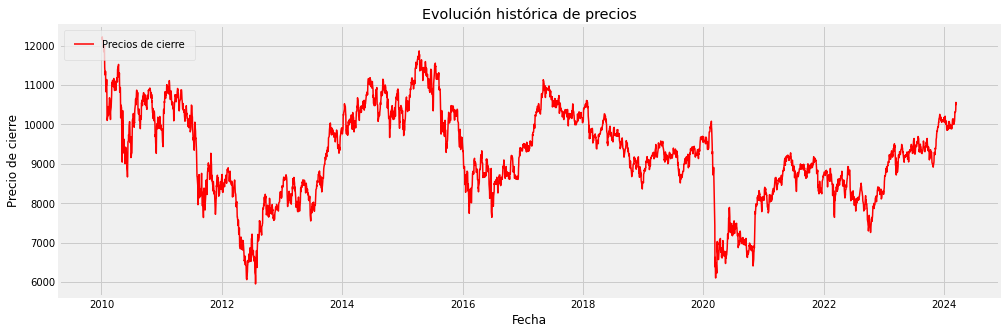

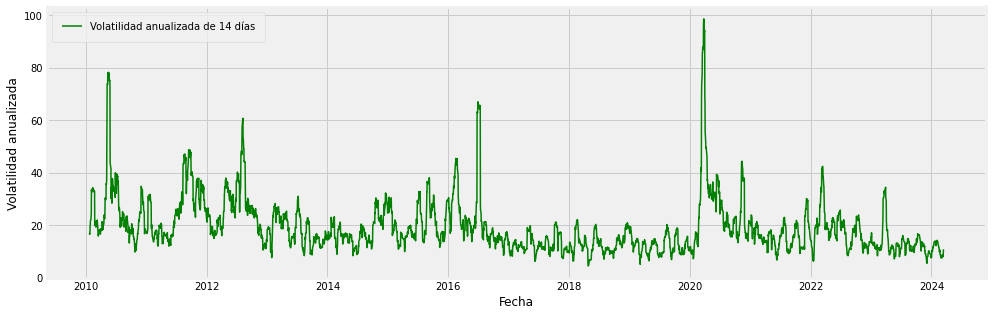

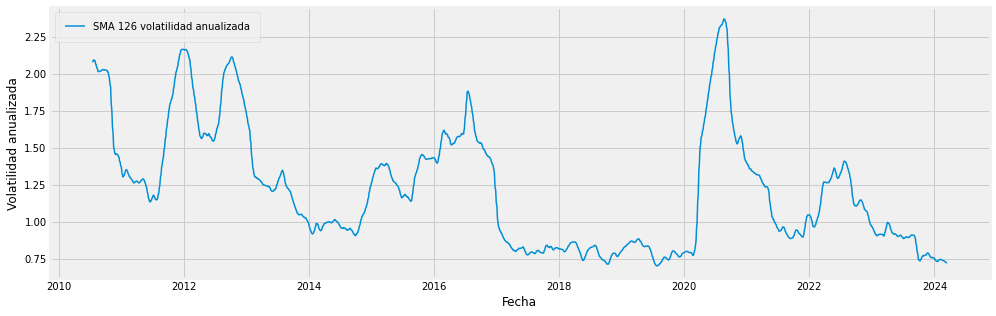

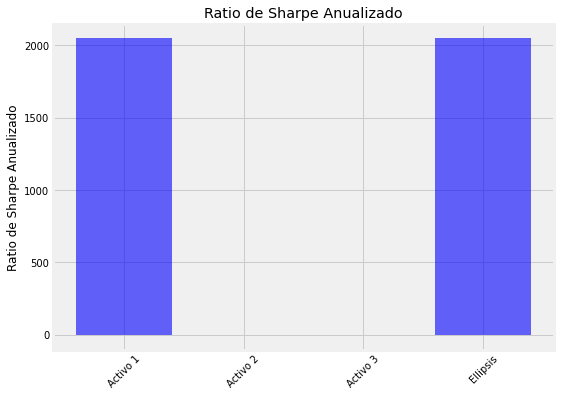

In [98]:
# Calcular Indicadores de riesgo
ticker = '^IBEX'
start_date = '2010-1-1'
end_date = '2024-3-15'

indicadores_riesgo = CalculadorIndicadoresRiesgo(ticker, start_date, end_date)
indicadores_riesgo.get_quotes()
indicadores_riesgo.calculate_variations()  # Calcular variaciones y retornos logarítmicos
indicadores_riesgo.buy_hold_strategy_profits()

indicadores_riesgo.calcular_estadisticos()

indicadores_riesgo.buy_hold_strategy_profits()
indicadores_riesgo.calcular_CAGR() 
indicadores_riesgo.calcular_drowdown()
indicadores_riesgo.calcular_estadisticos()
indicadores_riesgo.calculate_asimmetry()
indicadores_riesgo.theoretical_var()
indicadores_riesgo.historical_var ()
indicadores_riesgo.calculate_volatility()
#indicadores_riesgo.mostrar_volatilidad_ploty()
indicadores_riesgo.mostrar_volatilidad_matplotlib()
indicadores_riesgo.calcular_sharpe_anualizado()

In [83]:
class CalculadorIndicadoresRiesgo:
    def __init__(self, datos, df_val_ind):
        self.datos = datos
        self.df_val_ind = df_val_ind
        self.df_normalizado = None
        #self.log_retornos_diarios_val = np.log(self.datos["log_returns"] + 1)
        self.N = 255          # 255 días de bolsa en un año
        self.rf =0.01
        self.df_val_macd = None
        self.delta = None
        self.aux_dd = None
    
    def normalizar_cotizaciones(self):
        self.df_normalizado = self.df_val_ind.pct_change().dropna() 
        #self.df_normalizado['Media'] = self.df_normalizado.mean(axis = 1)     
        px.line((self.df_normalizado + 1).cumprod() ,y= self.df_normalizado.columns ,title=f"\nValor de 1€ invertido desde el { start}  hasta el {end} ")
                

        
    def calcular_sharpe_anualizado(self):              
        mean = self.datos.mean() * self.N - self.rf
        sigma = self.datos.std() * np.sqrt(self.N)
        self.Sharpe = mean / sigma
        self.sharpe_ratio_anual = (252**0.5) * self.Sharpe
        self.Sharpe.plot.bar() 
        #plt.ylabel('Ratio de Sharp')
        #plt.show()        
        
    def calcular_sortino(self):
        mean = self.datos.mean() * self.N -self.rf
        std_neg = self.datos[self.datos < 0].std()*np.sqrt(self.N)
        self.sortino = mean/std_neg
        self.sortino.plot.bar()
        plt.ylabel('Ratio de Sortino')
        plt.show        
        
    def calcular_drawdown(self ):
        self.aux_dd =   self.datos.copy(deep=True) 
        self.aux_dd["drawdown"] = self.aux_dd[nom_val] - self.aux_dd[nom_val].cummax()
        print ("Drawndown de "+ nom_val)
        # Dibuja el gráfico
        self.aux_dd[[nom_val,'drawdown']].plot(subplots = True, grid = True, legend = False)
        plt.fill_between(self.aux_dd.index, self.aux_dd.drawdown, color = 'green')
        plt.show()
        self.aux_dd["drawdown"].min()
        self.max_drawdown = self.aux_dd["drawdown"].min()        

    def calcular_max_drawdown(self):
        self.aux_dd =  self.datos.copy(deep=True)
        comp_ret = (self.aux_dd[nom_val] + 1).cumprod()
        peak = comp_ret.expanding(min_periods = 1).max()
        max_drawdown = np.array(comp_ret/peak)-1
        df_val_macd_drawdown = pd.DataFrame (max_drawdown,columns=['drawdown']) 
        df_val_macd_drawdown.plot(subplots = True, grid = True, legend = False)
        plt.fill_between(df_val_macd_drawdown.index, df_val_macd_drawdown.drawdown, color = 'green')
        plt.show()
        df_val_macd_drawdown["drawdown"].min()
        self.max_drawdown = df_val_macd_drawdown["drawdown"].min()        

        max_drawdown 
        
    def calcular_factor_recuperacion(self):
        factor_recuperacion = self.aux_dd[nom_val].iloc[-1] / -self.max_drawdown.min()

    def calcular_ratio_calmar(self):
        #self.ratio_calmar = self.datos.mean()*255/abs(self.dd_min)
        self.ratio_calmar = self.datos.mean()*255/abs(self.max_drawdown)        
        self.ratio_calmar.plot.bar()
        plt.ylabel('Calmar ratio')
        plt.show() 
        
    def calcular_RSI(self):
        datos = self.datos.copy(deep=True)
        self.delta = datos[nom_val].diff()
        up = self.delta.clip(lower=0)
        down = -1 * self.delta.clip(upper=0)
        ema_up = up.ewm(com=13, adjust=False).mean()
        ema_down = down.ewm(com=13, adjust=False).mean()
        rs = ema_up/ema_down

        datos['RSI'] = 100 - (100/(1 + rs))

        # Omita los primeros 14 días para tener valores reales
        datos = datos.iloc[14:]

        fig, ax = plt.subplots(1, 2, figsize=(21, 7))
        ax0 = datos[["RSI"]].plot(ax=ax[0])
        ax0.axhline(30, color="black")
        ax0.axhline(70, color="black")
        datos[[nom_val]].plot(ax=ax[1])        
                
        #print(datos)
        #fig, (ax1, ax2) = plt.subplots(2)
        #ax1.get_xaxis().set_visible(False)
        #fig.suptitle(f"\nRSI de {nom_val}")

        ##Predict Stock Market Direction
        #datos[nom_val].plot(ax=ax1)
        #ax1.set_ylabel('Precio (€)')
        #datos['RSI'].plot(ax=ax2)
        #ax2.set_ylim(0,100)
        #ax2.axhline(30, c ='r', linestyle='--')
        #ax2.axhline(70, color='r', linestyle='--')
        #ax2.set_ylabel('RSI')
        plt.show()

    def calcular_RSI_talib(self):
        # Calcula el RSI
        import talib as tb  
        datos_rsi = self.datos.copy(deep=True)
        datos_rsi.loc[:, "rsi"] = tb.RSI(datos_rsi[nom_val], 14) 

        import matplotlib.pyplot as plt

        fig, ax = plt.subplots(1, 2, figsize=(21, 7))
        ax0 = datos_rsi[["rsi"]].plot(ax=ax[0])
        ax0.axhline(30, color="black")
        ax0.axhline(70, color="black")
        #variaciones.log_retornos_diarios_acumulados_val.dropna().copy(deep=True).plot(ax=ax[1])

    def calcular_tracking_error(self):               
        self.datos = self.df_val_ind.copy(deep=True)
        self.datos["RetornosVal"] = self.datos[nom_val].pct_change()
        self.datos["RetornosRef"] = self.datos[nom_ref].pct_change()
        self.datos["TE"] = self.datos["RetornosVal"] - self.datos["RetornosRef"]
        self.TE = self.datos["TE"].std()*100       
        print (f"Tracking error {round(self.TE, 2)} %")        

    def calcular_RSI(self):
        delta = self.datos["RetornosVal"].diff()
        up = delta.clip(lower=0)
        down = -1 * delta.clip(upper = 0)
        ema_up = up.ewm(com = 13, adjust=False).mean()
        ema_down = down.ewm(com = 13, adjust = False).mean()
        rs = ema_up/ema_down

        self.datos['RSI'] = 100 - (100/(1 + rs))

        #  Para tener valores reales, se omiten los primeros 14 días.
        self.datos = self.datos.iloc[14:]

        fig, ax = plt.subplots(1, 2, figsize=(21, 7))
        ax0 = self.datos[["RSI"]].plot(ax=ax[0])
        ax0.axhline(30, color="red")
        ax0.axhline(70, color="red")
        self.datos[["log_returns"]].plot(ax=ax[1])        
        #_________________________________________________________________________________
        #print(self.datos)
        #fig, (ax1, ax2) = plt.subplots(2)
        #ax1.get_xaxis().set_visible(False)
        #fig.suptitle(nom_val)

        # Prever la dirección del mercado
        #self.datos[nom_val].plot(ax=ax1)
        #ax1.set_ylabel('Precio')
        #self.datos['RSI'].plot(ax=ax2)
        #ax2.set_ylim(0,100)
        #ax2.axhline(30, c ='r', linestyle='--')
        #ax2.axhline(70, color='r', linestyle='--')
        #ax2.set_ylabel('RSI')
        #plt.show()
        #________________________________________________________________________________________________
    def calcular_CAGR(self):
        self.df_val_cagr =  self.datos.copy(deep=True)
        dias = (self.df_val_cagr.index[-1] - self.df_val_cagr.index[0]).days
        self.CAGR = ((self.df_val_cagr["log_returns"][-1]) / self.df_val_cagr["log_returns"][1]) ** (365.0/dias) - 1
        print ('\nCAGR =',str(round(self.CAGR,4)*100)+"%")
        
    def calcular_mejor_rto_mensual(self):
        # variaciones.calc_log_retornos_diarios_val
        #cotiz_val[["log_returns"]][start:end]
        #self.mejor_mes = np.max(variaciones.variaciones_val["pct_camb_val"])
        self.mejor_mes = np.max(log_retornos_diarios_val)
        
        #self.mejor_mes = np.max(self.df_val_macd[self.nom_val])
        #print ('\n% cambio mejor mes =',str(round(self.mejor_mes,2)*100)+"%")
        
    def calcular_peor_rto_mensual(self):
        self.peor_mes = np.min(log_retornos_diarios_val)
        print ('\n% cambio peor mes =',str(round(self.peor_mes,2)*100)+"%")
        
    def calcular_porcentaje_meses_rentables(self):
        # % de meses rentables y % de meses no rentables
        variaciones_totales = log_retornos_diarios_val
        meses_positivos = 0
        meses_negativos = 0
        meses_planos = 0

        for counter, value in enumerate(variaciones_totales):
            if value > 0:
                meses_positivos = meses_positivos + 1
            if value < 0:
                meses_negativos = meses_negativos + 1

            if value == 0:
                meses_planos = meses_planos +1

        self.perc_meses_positivos = meses_positivos / (meses_positivos + meses_negativos + meses_planos)*100
        self.perc_meses_negativos = meses_negativos / (meses_positivos + meses_negativos + meses_planos)*100   


    def medias_retornos_cotizaciones(self):
        """Modificar para que sea mensual"""
        self.df_val_macd_var_positivas = variaciones.variaciones_val.query('log_pct_camb_val > 0')
        self.df_val_macd_var_negativas = variaciones.variaciones_val.query('log_pct_camb_val < 0')

        self.media_variaciones_positivas  = round(self.df_val_macd_var_positivas["log_pct_camb_val"].mean()*100,4) 
        self.media_variaciones_negativas  = round(self.df_val_macd_var_negativas["log_pct_camb_val"].mean()*100,4)
        
        # Beneficio mensual medio / Pérdida mensual media  
        try:
            self.relacion_meses_pos_neg = np.mean(self.df_val_macd_var_positivas["log_returns"]) / np.mean(self.df_val_macd_var_negativas[nom_val])

        except ZeroDivisionError:
            print (0)        

    def calcular_tabla_rtos_mensuales(self):        
        self.df_val_macd = self.variaciones.variaciones_val[["log_pct_camb_val"]].copy(deep=True)
        self.df_val_macd["mes"] = self.df_val_macd.index.month

        self.tabla_mensual =self.df_val_macd[["log_pct_camb_val",'mes']].pivot_table(self.df_val_macd[["log_pct_camb_val",'mes']], index=self.df_val_macd.index, columns='mes', aggfunc=np.sum).resample('A')
        self.tabla_mensual = self.tabla_mensual.aggregate('sum')

        # Elimina el índice de la columna de nivel superior que actualmente se muestra como "Estrategia"
        self.tabla_mensual.columns = self.tabla_mensual.columns.droplevel()

        #  Reemplaza la fecha completa en la columna de índice con el año correspondiente
        self.tabla_mensual.index = self.tabla_mensual.index.year

        # Reemplazamos los encabezados de las columnas con formato MMM
        self.tabla_mensual.columns = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']           
       # print (self.tabla_mensual)        

    def mostrar_tabla_indicadores(self):
        self.df_val_macd_tabla_indicadores = pd.DataFrame()
        self.df_val_macd_tabla_indicadores['sortino'] = self.sortino
        self.df_val_macd_tabla_indicadores['sharpe'] = self.sharpe_ratio_anual
        self.df_val_macd_tabla_indicadores['maxdd'] = self.max_drawdown
        self.df_val_macd_tabla_indicadores['calmar'] = self.ratio_calmar
        self.df_val_macd_tabla_indicadores["cagr"] = self.CAGR
        self.df_val_macd_tabla_indicadores["rsi"] = self.datos['RSI'][-1]        
        (self.df_val_macd+1).cumprod().plot(figsize = (8,5))
        plt.table(cellText = np.round(self.df_val_macd_tabla_indicadores.values,2), colLabels = self.df_val_macd_tabla_indicadores.columns,
        rowLabels = self.df_val_macd_tabla_indicadores.index,rowLoc = 'center',cellLoc = 'center',loc='top',
        colWidths = [0.25]*len(self.df_val_macd_tabla_indicadores.columns))
        plt.tight_layout()

    def imprimir_indicadores(self):
        # Imprimir resultados
        print("\n*****************************************************************************************************************")
        print(f"\nINDICADORES RIESGO / BENEFICIO. Período del {self.start} al {self.end}")
        #print (f"\nINDICADORES RIESGO / BENEFICIO. Período del {self.start} al {self.end}")
        print("\n*****************************************************************************************************************")       
        
        print("\n*****************************************************************************************************************")
        print("\nVOLATILIDAD")
        print ('\nVolatilidad datos diarios =',str(round(self.volatilidad_diaria,4)*100)+"%")
        print ('\nVolatilidad usando datos mensuales =',str(round(self.volatilidad_mensual,4)*100)+"%") 
        
        print("\n*****************************************************************************************************************")
        print("\n RATIO DE SHARPE")        
        print ("\nSharp anualizado : ", self.sharpe_ratio_anual)
        print ("\nSharp. Emplear solamente para comparar inversiones homogéneas ")
        print ("\ncuanto mayor sea la Sharpe Ratio, mejor es la rentabilidad del fondo en relación al riesgo asumido. ")
        print ("\nSharp. En general, mayor de uno es considerado muy positivo.")
        print ("\nLos números más altos se relacionan con inversiones mejor ajustadas al riesgo.")
        print ("\nPara fondos de rentabilidad absoluta 0,5 se considera bueno ") 
            
        print("\n*****************************************************************************************************************")
        print("\nRATIO DE SORTINO")        
        print ("\nSortino  : ", self.sortino)
        print ("\nNos indica la rentabilidad que esperamos obtener en función del riesgo de caídas que tiene nuestra inversión. ")
        print ("\nCuanto mayor sea la Ratio Sortino, mejor será la relación entre rentabilidad y riesgo.")       
       
        print("\n*****************************************************************************************************************")
        print("\nFACTOR DE RECUPERACION")
        #print ("Factor de Recuperación : ",  self.factor_recuperacion)        

        print("\n*****************************************************************************************************************")
        print("\nMAXIMO DRAWDOWN")        
        #print ("\nMáximo drawdown  : ", self.max_drawdown[-1] )           
        #print (f"\nFactor de recuperación de {nom_val} : {self.factor_recuperacion}")
        print ("\nUn índice alto sugiere que el retorno de la inversión no corría riesgo de pérdidas significativas.")
        print (" \nPor otro lado, un ratio bajo indica que el riesgo de pérdidas es mayor." )

        print("\n*****************************************************************************************************************")
        print("\nTASA DE CRECIMIENTO ANUAL CAGR")        
        print ("\n Tasa de crecimiento anual compuesta (CAGR) (TAE)  : ", self.CAGR  )
        print ("\nCAGR nos indica de esta inversión ha sido positivo o negativo.")
        print ("\nEs válido para hacer una primera aproximación, pero debemos combinarlo con otros más complejos que integren otro tipo de variables para saber si una inversión nos conviene o no.")                

        print("\n*****************************************************************************************************************")
        print("\nRATIO DE CALMAR")        
        print ("\nRatio de Calmar  : ", self.ratio_calmar )
        print ("\nUn índice alto sugiere que el retorno de la inversión no corría riesgo de pérdidas significativas.")
        print ("\nUn ratio bajo indica que el riesgo de pérdidas es mayor.  ")                 

        print("\n*****************************************************************************************************************")              
        print("\nINDICE DE FUERZA RELATIVA, RSI")
        print ("\nIndice de Fuerza Relativa RSI  : ", self.datos['RSI'][-1] )
        print ("\nAlrededor del nivel 30: refleja niveles de sobreventa e indica que los precios han caído bruscamente y ahora el movimiento podría perder fuerza.")
        print ("\nalrededor del nivel 70: refleja niveles de sobrecompra, e indica que los precios han subido bruscamente y es probable que el movimiento se debilite.")
        print ("\noSi oscila horizontalmente alrededor del nivel de 50: significa que el mercado carece de una tendencia.")
        print ("\nEl nivel 50 es la línea media que separa los territorios alcistas y bajistas del indicador.")
        print ("\nEl cruce de los niveles de 30, 50 y 70 da señales de trading")
        print ("\nSe deberá vender cuando el RSI empieza a descender y pierde el límite de 70.")
        print ("\nSe deberá comprar cuando el RSI empieza a subir y supera el límite de 30")                

        print("\n*****************************************************************************************************************")              
        print("\nTRACKING ERROR")        
        print (f"Tracking error {self.TE} %")        
        print ("\nDesviación de la rentabilidad del fondo con respecto a su índice de referencia. ")               
        print ("\nEntre 0% y 2% hablaríamos de una gestión pasiva.  ")
        print ("\nEntre 2% y 5%, estaríamos ante una gestión con un poco más de riesgo, pero controlad ")
        print ("\nUn fondo con un tracking error superior al 5% indicaría que estaríamos ante una gestión activa. ")                     

        print("\n*****************************************************************************************************************")
        print("\nTASA DE CRECIMIENTO ANUAL COMPUESTO, CAGR")        
        print (f"Tasa de crecimiento anual compuesto {self.CAGR} %")        

        print("\n*****************************************************************************************************************")           
        print("\nMEJOR RENDIMIENTO MENSUAL")        
        print ('\n% cambio mejor mes =',str(round(self.mejor_mes,2)*100)+"%")      

        print("\n*****************************************************************************************************************")           
        print("\nPEOR RENDIMIENTO MENSUAL")        
        print ('\n% cambio mejor mes =',str(round(self.peor_mes,2)*100)+"%")              

        print("\n*****************************************************************************************************************")
        print("\nPORCENTAJE DE MESES RENTABLES")        
        print ("%meses_positivos ", self.perc_meses_positivos , "%meses negativos ", self.perc_meses_negativos)              
        print("\n*****************************************************************************************************************")                      

        print("\nMEDIA DE LAS COTIZACIONES Y DE LOS RETRONOS POSITIVOS")        
        print (f"\nMedia de retornos positivos {self.media_variaciones_positivas}  %")
        print (f"\nMedia de retornos negativos{self.media_variaciones_negativas}  %") 
        # Pérdida mensual promedio
        print (f"\nMedia de las cotizaciones positivas   {np.mean(self.df_val_macd_var_positivas[nom_val])} ")        
        #print ('\nBeneficio mensual medio/Pérdida mensual promedio ',self.media_variaciones_positivas / self.media_variaciones_negativastivas)               

        print("\n*****************************************************************************************************************")              
        print("\nRELACION MESES POSITIVOS / MESES NEGATIVOS")        
        print (f"Tabla de rencimientos mensuales {self.relacion_meses_pos_neg} ")                      
        print("\n*****************************************************************************************************************")                     

        print("\n*****************************************************************************************************************")              
        print("\nTABLA DE RENTABILIDADES MENSUALES")        
        print (f"Tabla de rencimientos mensuales {self.tabla_mensual} ")                      
        print("\n*****************************************************************************************************************")                     

            
    def calcular(self):
        print("\n*****************************************************************************************************************" )
        print(f"\nINDICADORES DE RIESGO")
        print("\n*****************************************************************************************************************" )
        #indicadores_riesgo.normalizar_cotizaciones()
        #indicadores_riesgo.calcular_volatilidad()
        indicadores_riesgo.calcular_sharpe_anualizado()
        indicadores_riesgo.calcular_sortino()
        indicadores_riesgo.calcular_RSI()
        #indicadores_riesgo.calcular_RSI_talib()
        indicadores_riesgo.calcular_drawdown()
        # revisar factor recuperacion
        #indicadores_riesgo.calcular_factor_recuperación()
        """TypeError: 'NoneType' object is not subscriptable"""
        #indicadores_riesgo.calcular_tracking_error()        
        indicadores_riesgo.calcular_ratio_calmar()
        #indicadores_riesgo.calcular_RSI()
        indicadores_riesgo.calcular_CAGR()
        indicadores_riesgo.calcular_mejor_rto_mensual()
        indicadores_riesgo.calcular_peor_rto_mensual()        
        indicadores_riesgo.calcular_porcentaje_meses_rentables()
        indicadores_riesgo.medias_retornos_cotizaciones() 
        indicadores_riesgo.calcular_tabla_rtos_mensuales()
        indicadores_riesgo.calcular_tabla_rtos_mensuales()
        indicadores_riesgo.imprimir_indicadores()
        indicadores_riesgo.mostrar_tabla_indicadores()
        

       


*****************************************************************************************************************

INDICADORES DE RIESGO

*****************************************************************************************************************


KeyError: 'RetornosVal'

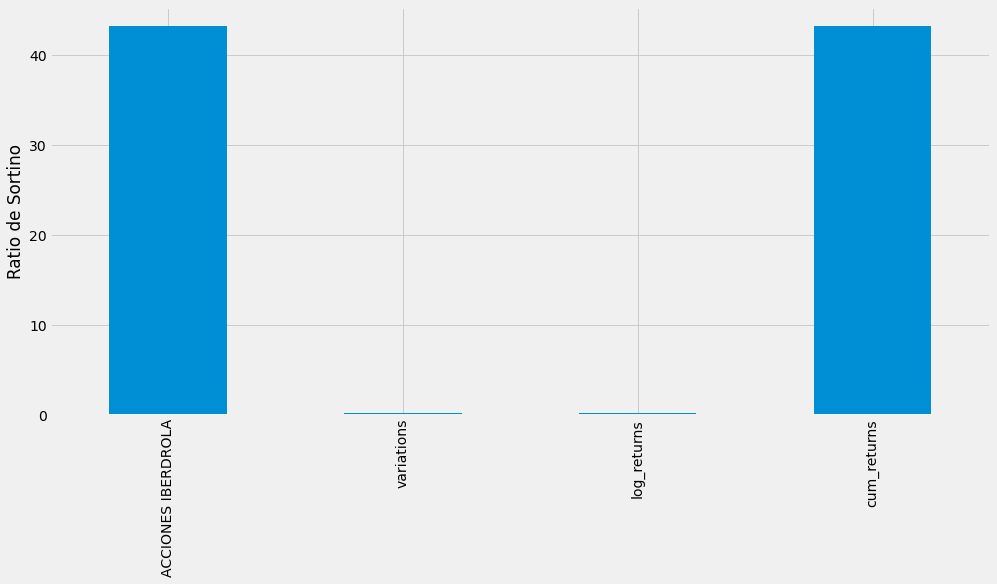

In [30]:
# Calcular Indicadores de riesgo
datos = df_value.copy(deep=True)
indicadores_riesgo = CalculadorIndicadoresRiesgo(datos, df_val_ind)
indicadores_riesgo.calcular() 